# Acoustic FWI parametrized in velocity using only refractions

## Author: M. Ravasi

This notebook performs acoustic FWI parametrized in velocity using only refracted arrivals. It is mostly aimed at showcasing the ``devitofwi.preproc.masking.TimeSpaceMasking`` method to mask both the observed and modelled data (the latter as part of the objective function computation) and uses the ``devitofwi.fwi.acoustic.AcousticFWI2D`` driver to setup and run the entire inversion proces.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from devito import configuration
from itertools import chain
from pylops.basicoperators import Diagonal, Identity

from tqdm.notebook import tqdm
from examples.seismic import AcquisitionGeometry, Model, Receiver
from examples.seismic import plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_shotrecord

from devitofwi.devito.utils import clear_devito_cache
from devitofwi.waveengine.acoustic import AcousticWave2D
from devitofwi.preproc.masking import TimeSpaceMasking
from devitofwi.loss.l2 import L2
from devitofwi.postproc.acoustic import PostProcessVP
from devitofwi.fwi.acoustic import AcousticFWI2D

configuration['log-level'] = 'ERROR'

In [2]:
clear_devito_cache()

In [3]:
# Callback to track model error
def fwi_callback(xk, vp, vp_error):
    vp_error.append(np.linalg.norm((xk - vp.reshape(-1))/vp.reshape(-1)))

## Parameters 

In [4]:
# Model and aquisition parameters
par = {'nx':601,   'dx':15,    'ox':0,
       'nz':221,   'dz':15,    'oz':0,
       'ns':20,    'ds':300,   'os':1000,  'sz':0,
       'nr':300,   'dr':30,    'or':0,     'rz':0,
       'nt':3000,  'dt':0.002, 'ot':0,
       'freq':7,
      }

# Modelling parameters
shape = (par['nx'], par['nz'])
spacing = (par['dx'], par['dz'])
origin = (par['ox'], par['oz'])
space_order = 4
nbl = 20

# Velocity model
path = '../../data/'
velocity_file = path + 'Marm.bin'

# Time-space mask parameters
vwater = 1500
toff = 0.35

## Acquisition set-up

In [5]:
# Sampling frequency
fs = 1 / par['dt'] 

# Axes
x = np.arange(par['nx']) * par['dx'] + par['ox']
z = np.arange(par['nz']) * par['dz'] + par['oz']
t = np.arange(par['nt']) * par['dt'] + par['ot']
tmax = t[-1] * 1e3 # in ms

# Sources
x_s = np.zeros((par['ns'], 2))
x_s[:, 0] = np.arange(par['ns']) * par['ds'] + par['os']
x_s[:, 1] = par['sz']

# Receivers
x_r = np.zeros((par['nr'], 2))
x_r[:, 0] = np.arange(par['nr']) * par['dr'] + par['or']
x_r[:, 1] = par['rz']

## Velocity model

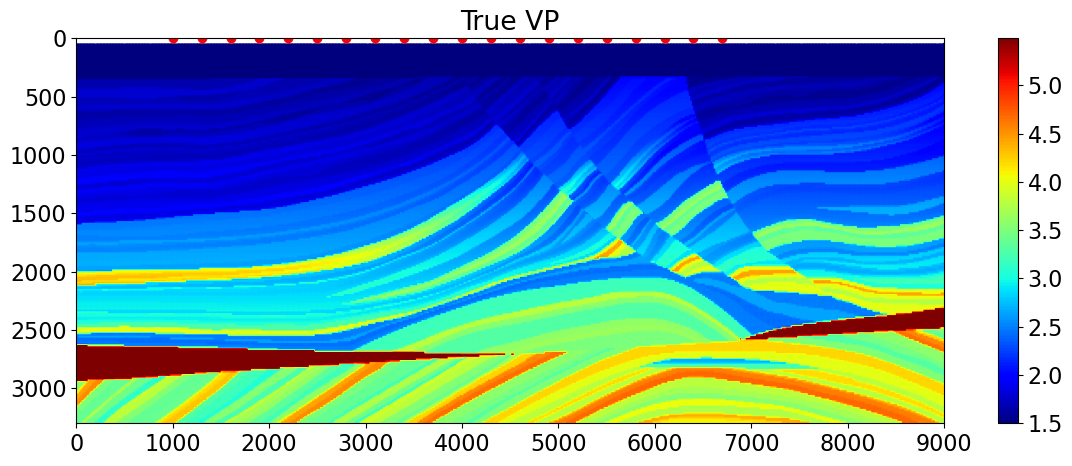

In [6]:
# Function to get water layer mask
def mask(m, value):
    """Mask for model below given value
    """
    msk = m > value
    msk = msk.astype(int)
    return msk

# Load the true model
vp_true = np.fromfile(velocity_file, np.float32).reshape(par['nz'], par['nx']).T
msk = mask(vp_true, 1.52) # get the mask for the water layer 

m_vmin, m_vmax = np.percentile(vp_true, [2,98]) 

plt.figure(figsize=(14, 5))
plt.imshow(vp_true.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
           extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('True VP')
plt.axis('tight');

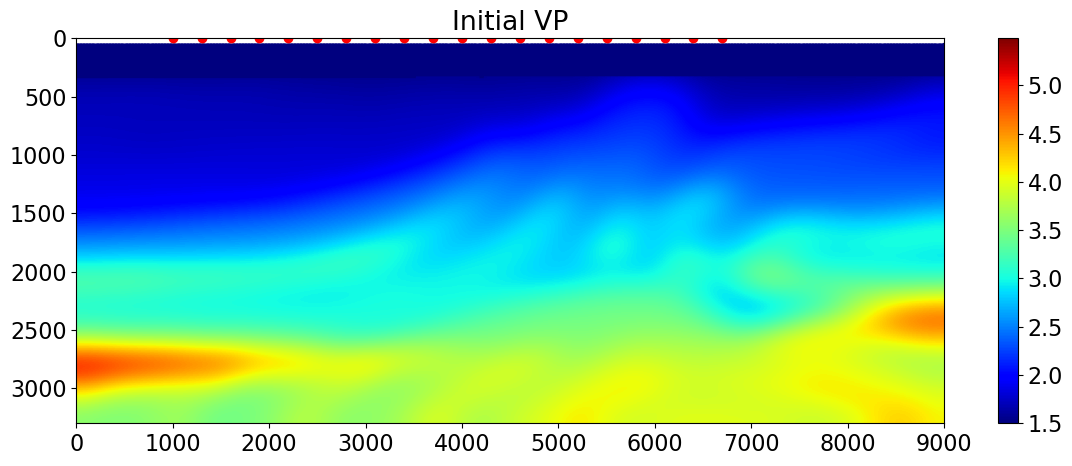

In [7]:
# Initial model for FWI by smoothing the true model
vp_init = gaussian_filter(vp_true, sigma=[15,10])
vp_init = vp_init * msk  # to preserve the water layer  
vp_init[vp_init == 0] = 1.5

plt.figure(figsize=(14, 5))
plt.imshow(vp_init.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', 
extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Initial VP')
plt.axis('tight');

## Data modelling

In [8]:
# Define modelling engine
amod = AcousticWave2D(shape, origin, spacing, 
                      x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                      0., tmax,  
                      vp=vp_true * 1e3, 
                      src_type="Ricker", f0=par['freq'],
                      space_order=space_order, nbl=nbl);

In [9]:
# Model data
dobs = amod.mod_allshots()

  0%|          | 0/20 [00:00<?, ?it/s]

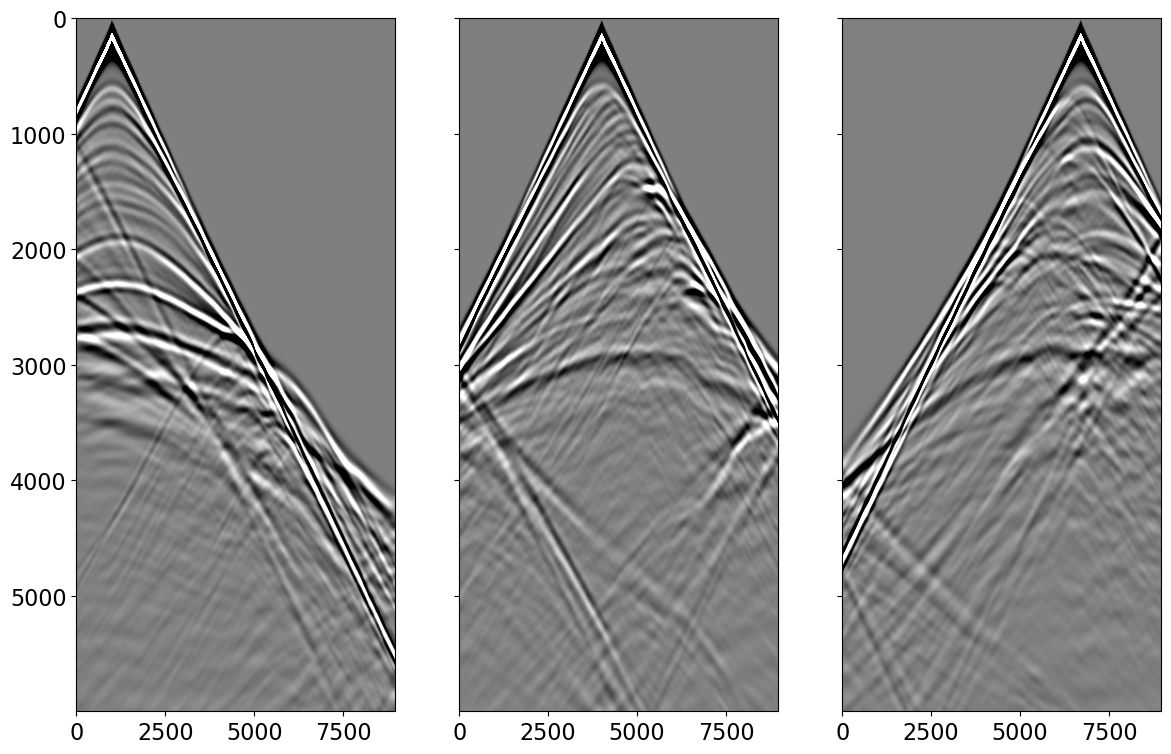

In [10]:
# Plot shot gathers
d_vmin, d_vmax = np.percentile(np.hstack(dobs).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)

## Mask creation

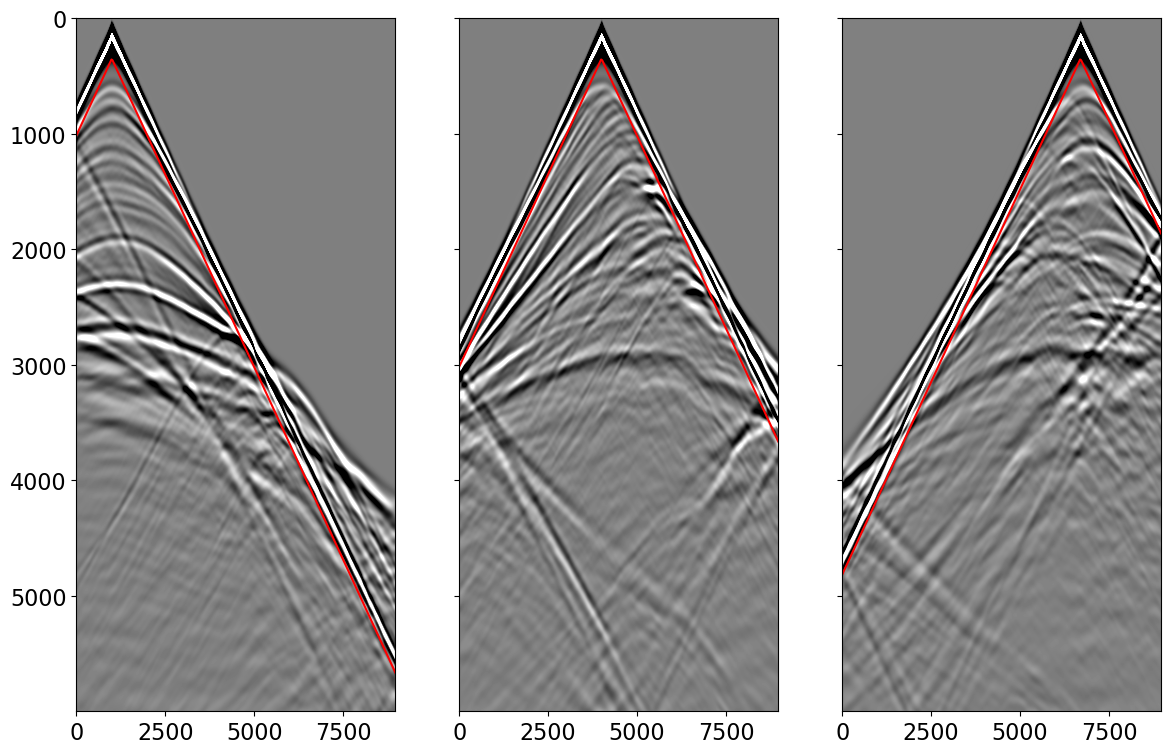

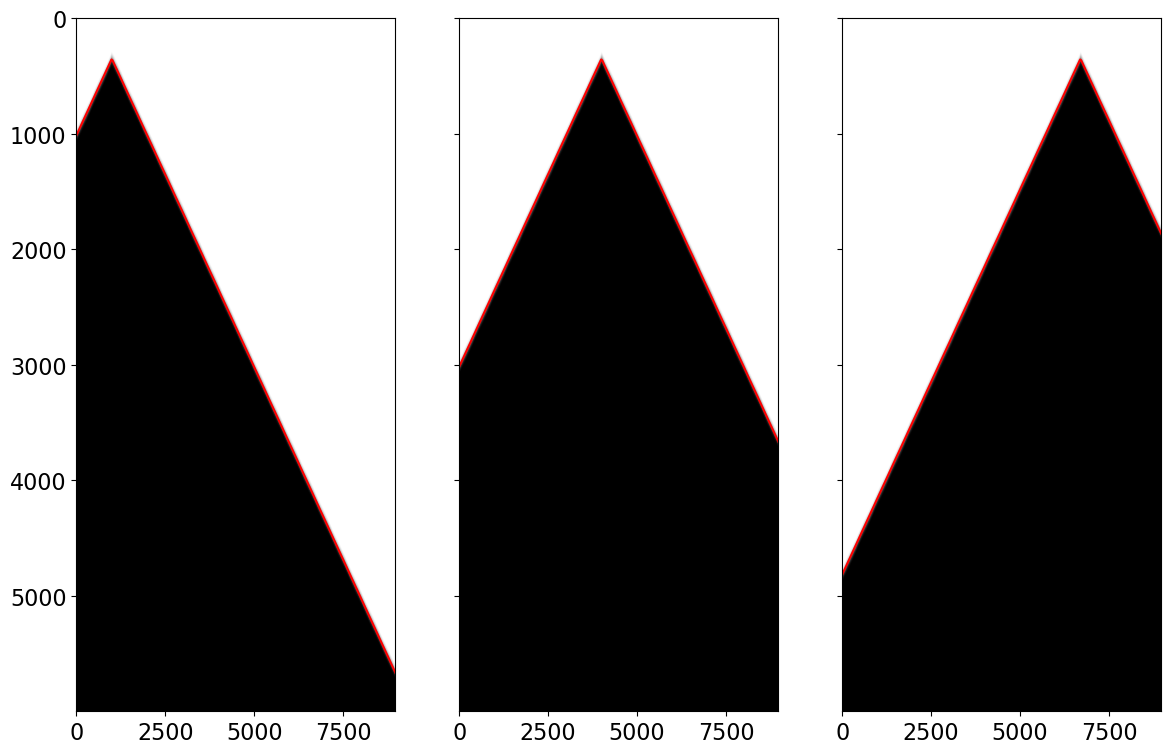

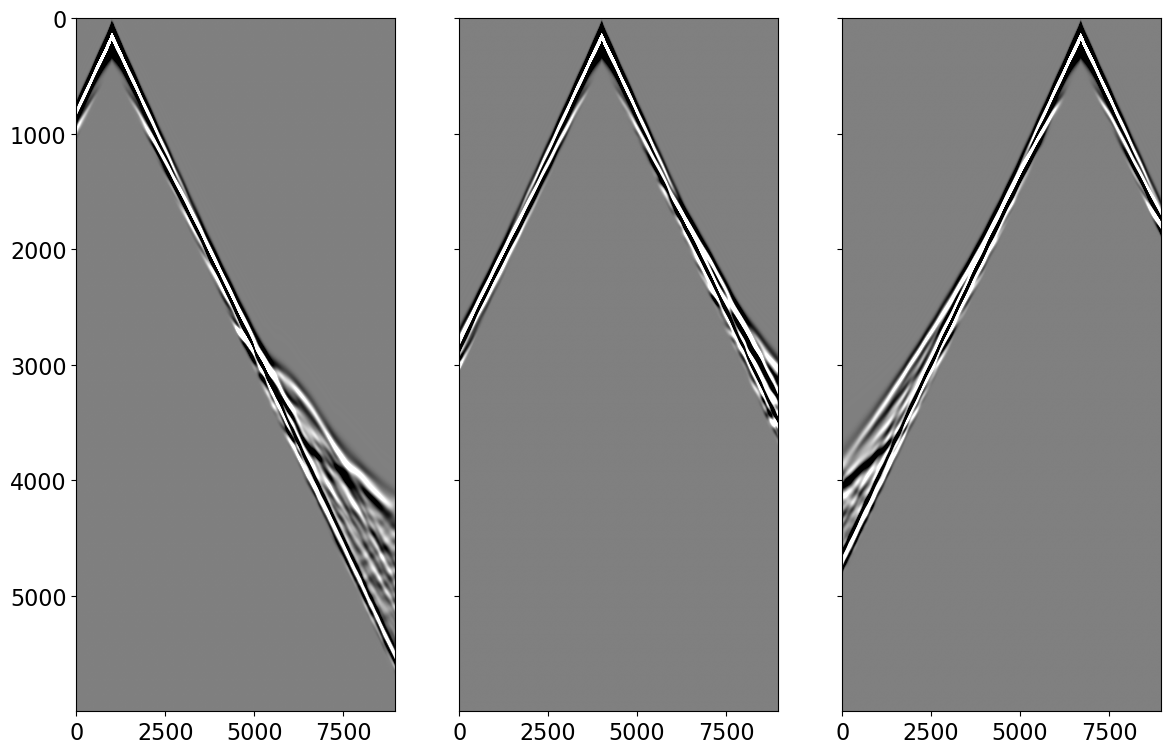

In [11]:
# Create direct arrival mask
distance = np.sqrt((x_s[:, 0][:, None]-x_r[:, 0][None, :])**2 + (x_s[:, 1][:, None]-x_r[:, 1][None, :])**2)
directtime = distance / vwater
tsmask = TimeSpaceMasking(directtime, amod.geometry.nt, amod.geometry.dt * 1e-3, toff, nsmooth=50)

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff) * 1000, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=0, vmax=1)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff) * 1000, 'r')
    
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs[ishot] * tsmask.mask[ishot].T, aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax);

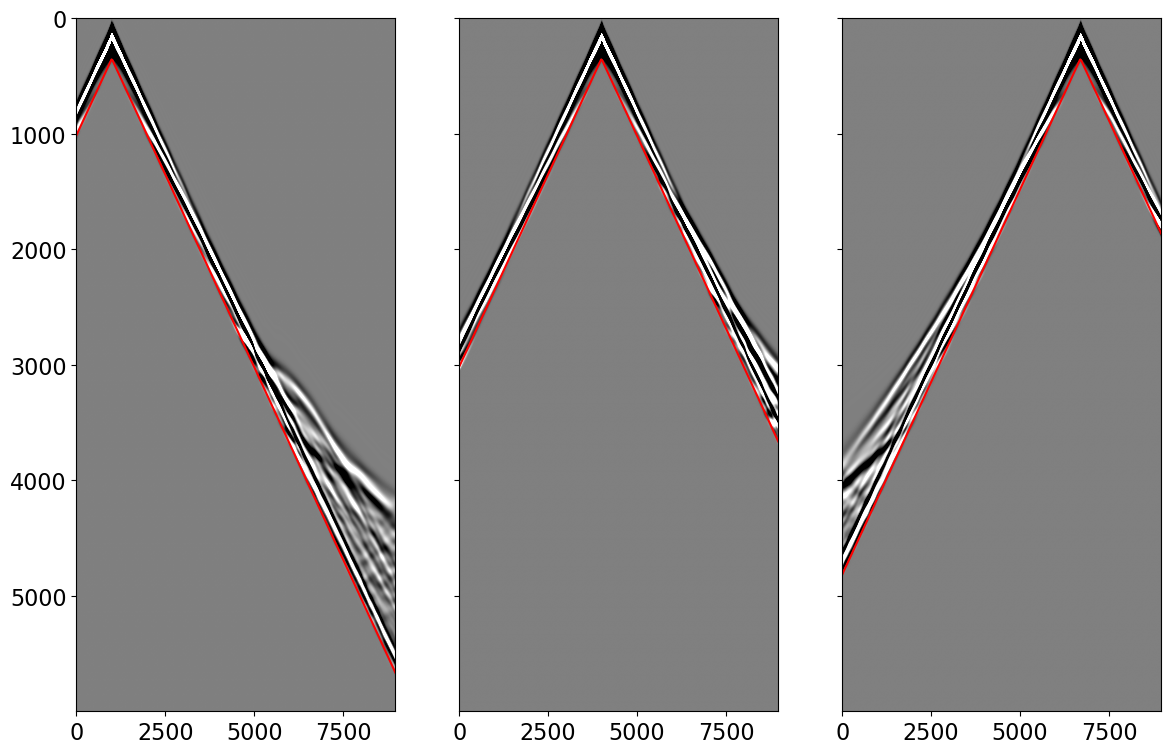

In [12]:
# Mask observed data to have direct arrival and refractions
TSmaskop = [Diagonal(tsmask.mask[isrc].T.ravel()) for isrc in range(par['ns'])]
dobs_masked = np.hstack([(TSmaskop[isrc] @ dobs[isrc].ravel())[None, :] for isrc in range(par['ns'])])
dobs_masked = dobs_masked.reshape(par['ns'], amod.geometry.nt, par['nr'])

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot], aspect='auto', cmap='gray',
              extent=(x_r[0, 0], x_r[-1, 0], tmax, 0.,),
              vmin=-d_vmax, vmax=d_vmax)
    ax.plot(x_r[:, 0], (directtime[ishot] + toff) * 1000, 'r')

## Inversion with L-BFGS

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       132821     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.76495D+02    |proj g|=  1.01148D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    1    f=  5.47570D+02    |proj g|=  1.00755D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    2    f=  4.24406D+02    |proj g|=  1.07279D+00


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    3    f=  2.94309D+02    |proj g|=  5.58919D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    4    f=  2.38781D+02    |proj g|=  3.65109D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    5    f=  1.92857D+02    |proj g|=  4.42526D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    6    f=  1.72296D+02    |proj g|=  2.30723D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    7    f=  1.48766D+02    |proj g|=  1.37721D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    8    f=  1.39749D+02    |proj g|=  1.69128D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate    9    f=  1.25049D+02    |proj g|=  1.82738D-01


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   10    f=  1.18939D+02    |proj g|=  1.38053D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   11    f=  1.08078D+02    |proj g|=  2.30293D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   12    f=  9.74137D+01    |proj g|=  1.29145D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   13    f=  8.74065D+01    |proj g|=  1.11775D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   14    f=  8.70825D+01    |proj g|=  2.41971D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   15    f=  7.95406D+01    |proj g|=  1.17258D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   16    f=  7.54578D+01    |proj g|=  6.44469D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   17    f=  7.24477D+01    |proj g|=  8.94701D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   18    f=  6.76870D+01    |proj g|=  1.03054D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   19    f=  6.70824D+01    |proj g|=  1.32383D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   20    f=  6.23200D+01    |proj g|=  5.36928D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   21    f=  5.93001D+01    |proj g|=  6.22646D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   22    f=  5.67898D+01    |proj g|=  9.30564D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   23    f=  5.53419D+01    |proj g|=  6.99707D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   24    f=  5.28520D+01    |proj g|=  5.48836D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   25    f=  5.25771D+01    |proj g|=  1.69938D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   26    f=  5.00995D+01    |proj g|=  5.45016D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   27    f=  4.87744D+01    |proj g|=  3.54282D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   28    f=  4.77458D+01    |proj g|=  5.29640D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   29    f=  4.58991D+01    |proj g|=  9.52230D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   30    f=  4.58047D+01    |proj g|=  1.33478D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   31    f=  4.37859D+01    |proj g|=  4.47294D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   32    f=  4.28045D+01    |proj g|=  4.61728D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   33    f=  4.16567D+01    |proj g|=  4.95996D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   34    f=  4.01905D+01    |proj g|=  7.99681D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   35    f=  3.97536D+01    |proj g|=  5.21652D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   36    f=  3.87416D+01    |proj g|=  5.68747D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   37    f=  3.77547D+01    |proj g|=  5.11800D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   38    f=  3.62372D+01    |proj g|=  9.92595D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   39    f=  3.56354D+01    |proj g|=  1.27740D-01


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   40    f=  3.44839D+01    |proj g|=  5.94040D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   41    f=  3.39197D+01    |proj g|=  5.19152D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   42    f=  3.34873D+01    |proj g|=  5.80793D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   43    f=  3.29554D+01    |proj g|=  9.27658D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   44    f=  3.27587D+01    |proj g|=  7.13589D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   45    f=  3.21363D+01    |proj g|=  3.57387D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   46    f=  3.17128D+01    |proj g|=  4.25042D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   47    f=  3.10955D+01    |proj g|=  6.25167D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   48    f=  3.04623D+01    |proj g|=  7.25886D-02


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   49    f=  3.02793D+01    |proj g|=  5.87006D-02


  0%|          | 0/20 [00:00<?, ?it/s]


At iterate   50    f=  2.96233D+01    |proj g|=  2.96844D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
*****     50     56      1     0     0   2.968D-02   2.962D+01
  F =   29.623321831793515     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


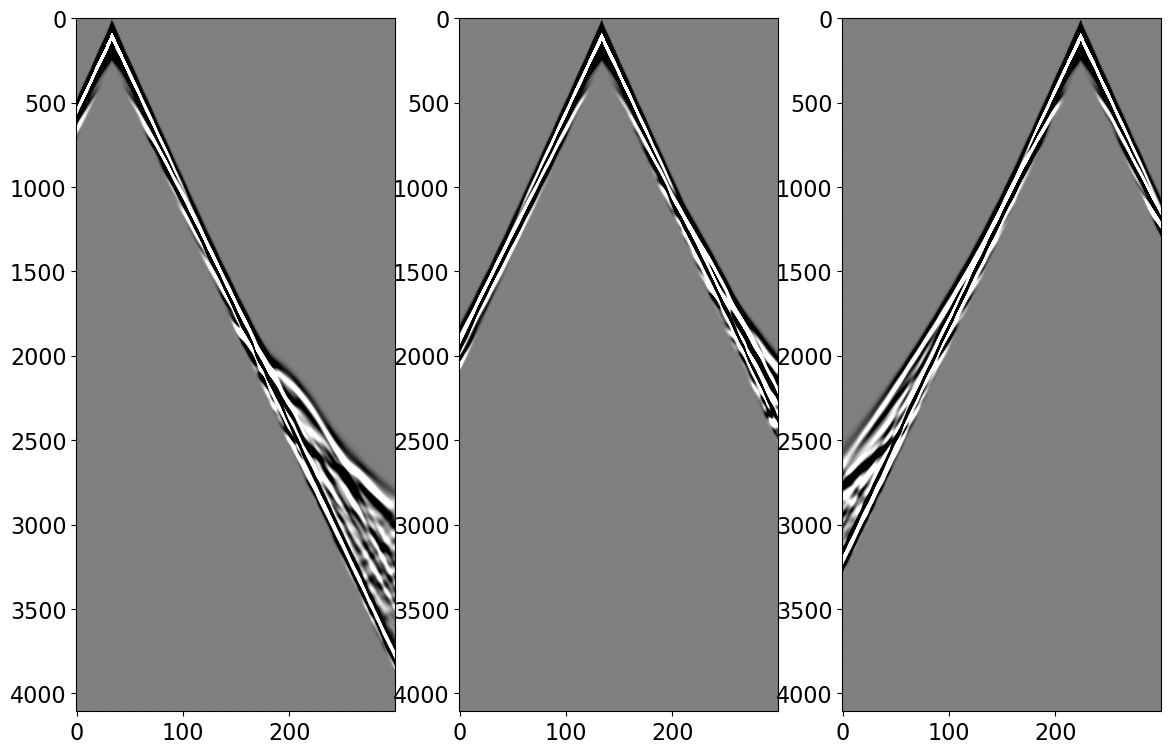

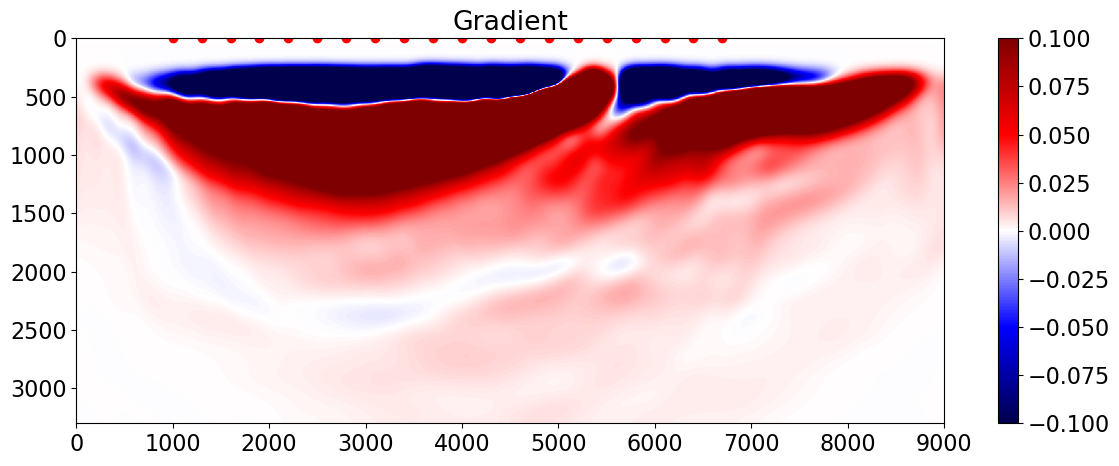

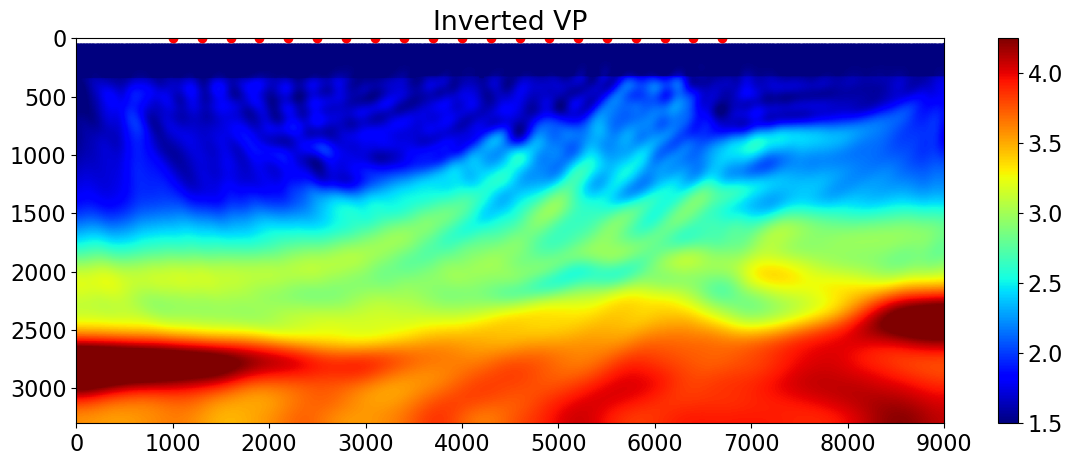

In [13]:
# Define loss (to which we add the mask as a diagonal linear operator applied to the modelled data
wav = amod.geometry.src.wavelet
postprocess = PostProcessVP(scaling=1, mask=msk, sigmas=(4, 4))
vp_error_hist = []

afwi = AcousticFWI2D(par, vp_init=vp_init * 1e3, vp_range=(vp_true.min() * 1e3, vp_true.max() * 1e3),
                     wav=wav, loss=L2, lossop=TSmaskop,
                     space_order=space_order, nbl=nbl, 
                     firstscaling=True, postprocess=postprocess, solver='L-BFGS-B',
                     kwargs_solver={'ftol':1e-10, 'maxiter':50, 'maxfun':200, 'disp':True},
                     callback=lambda x: fwi_callback(x, vp=vp_true, vp_error=vp_error_hist))

vp_inv, loss_hist, nl = afwi.run(dobs_masked, plotflag=True)

In [14]:
nl

  message: STOP: TOTAL NO. of ITERATIONS REACHED LIMIT
  success: False
   status: 1
      fun: 29.623321831793515
        x: [ 1.500e+00  1.500e+00 ...  4.088e+00  4.089e+00]
      nit: 50
      jac: [ 0.000e+00  0.000e+00 ...  8.723e-06  9.174e-06]
     nfev: 56
     njev: 56
 hess_inv: <132821x132821 LbfgsInvHessProduct with dtype=float64>

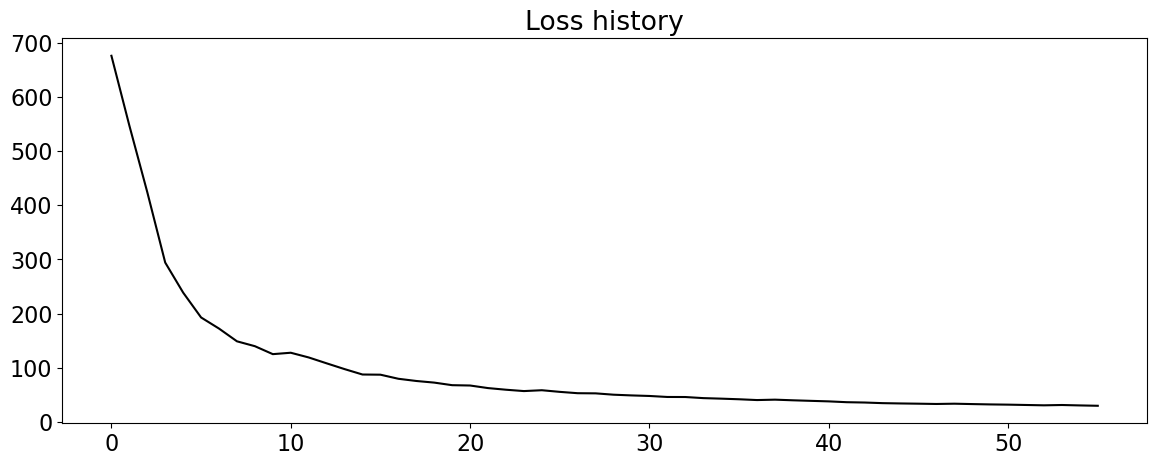

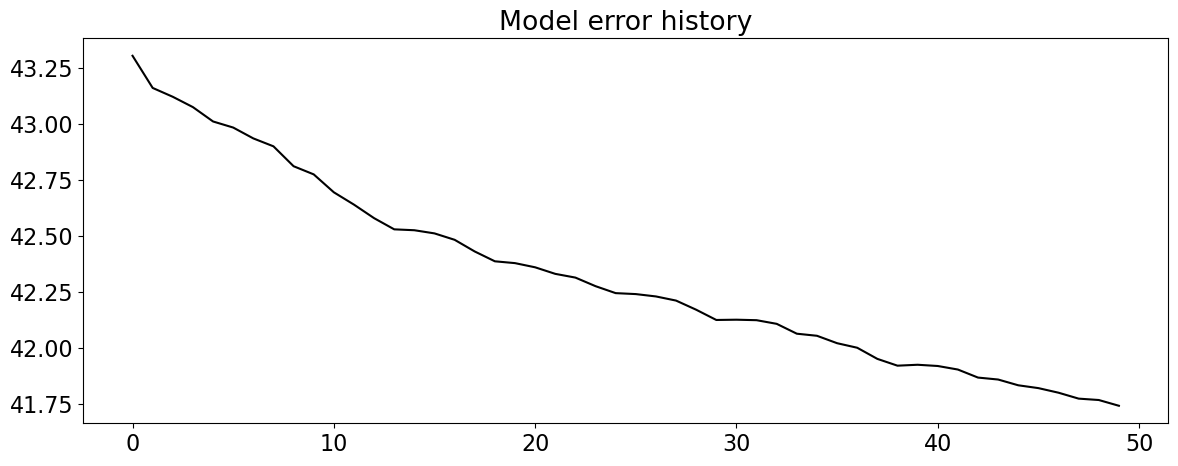

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(list(chain.from_iterable(loss_hist)), 'k')
plt.title('Loss history')

plt.figure(figsize=(14, 5))
plt.plot(vp_error_hist, 'k')
plt.title('Model error history');

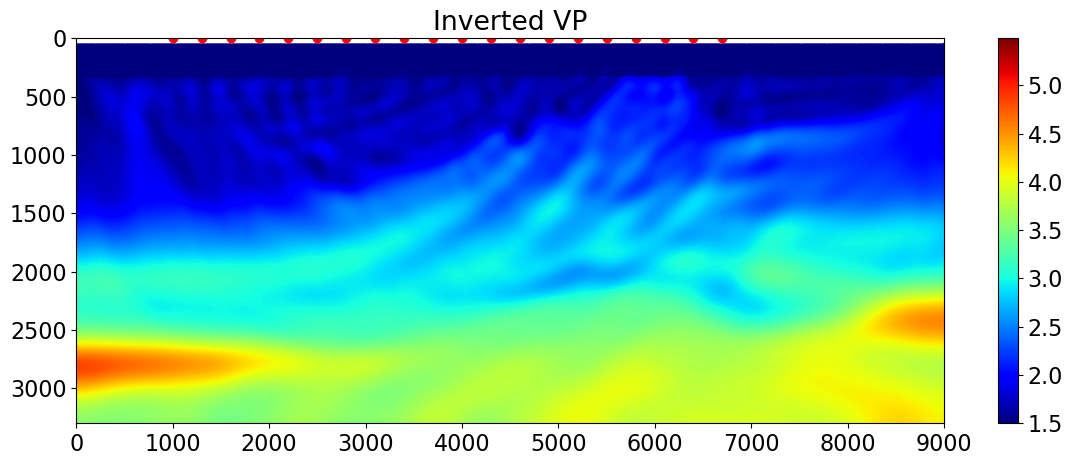

In [16]:
vp_inv = nl.x.reshape(shape)

plt.figure(figsize=(14, 5))
plt.imshow(vp_inv.T, vmin=m_vmin, vmax=m_vmax, cmap='jet', extent=(x[0], x[-1], z[-1], z[0]))
plt.colorbar()
plt.scatter(x_r[:,0], x_r[:,1], c='w')
plt.scatter(x_s[:,0], x_s[:,1], c='r')
plt.title('Inverted VP')
plt.axis('tight');

In [17]:
# Model data with inverted velocity model and compare with observed data
ainvfinal = AcousticWave2D(shape, origin, spacing, 
                           x_s[:, 0], x_s[:, 1], x_r[:, 0], x_r[:, 1], 
                           0., tmax,  
                           vp=vp_inv * 1e3, 
                           src_type="Ricker", f0=par['freq'],
                           space_order=space_order, nbl=nbl)
#plot_velocity(ainvfinal.model, ainvfinal.geometry.src_positions, 
#              ainvfinal.geometry.rec_positions)

dinv = ainvfinal.mod_allshots(dt=amod.geometry.dt)

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
# Mask predicted data
dinv_masked = np.hstack([(TSmaskop[isrc] @ dinv[isrc, :dobs.shape[1]].ravel())[None, :] for isrc in range(par['ns'])])
dinv_masked = dinv_masked.reshape(par['ns'], amod.geometry.nt, par['nr'])

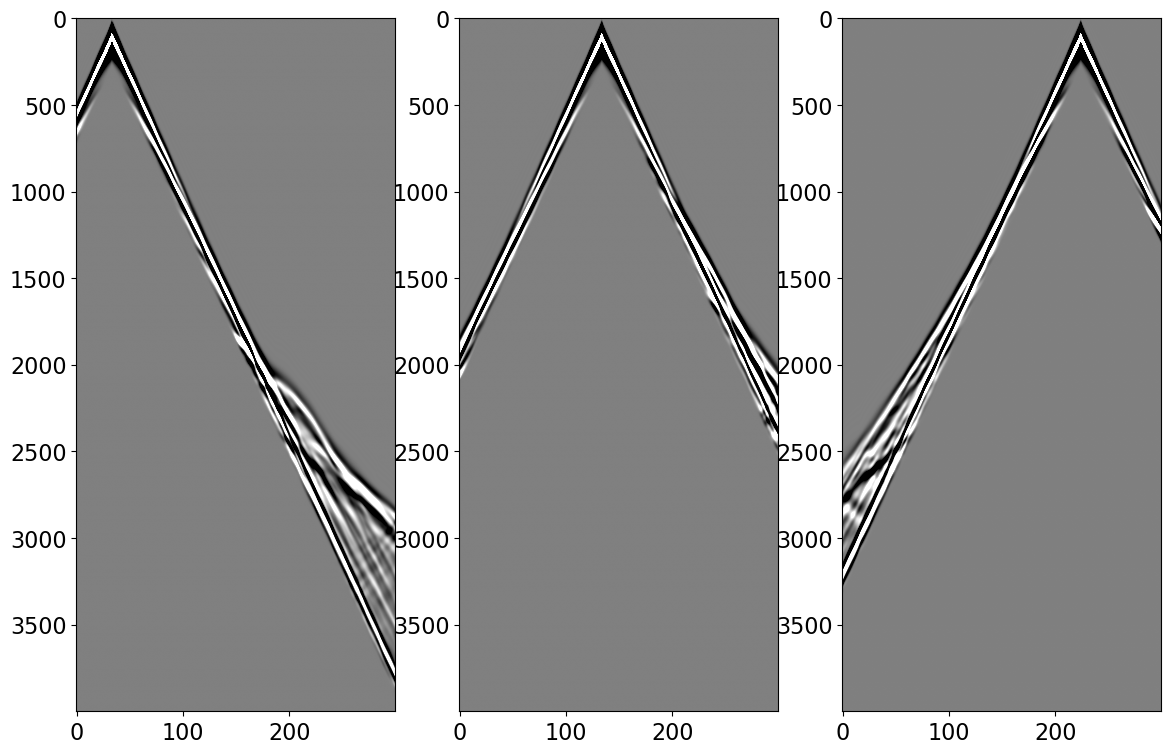

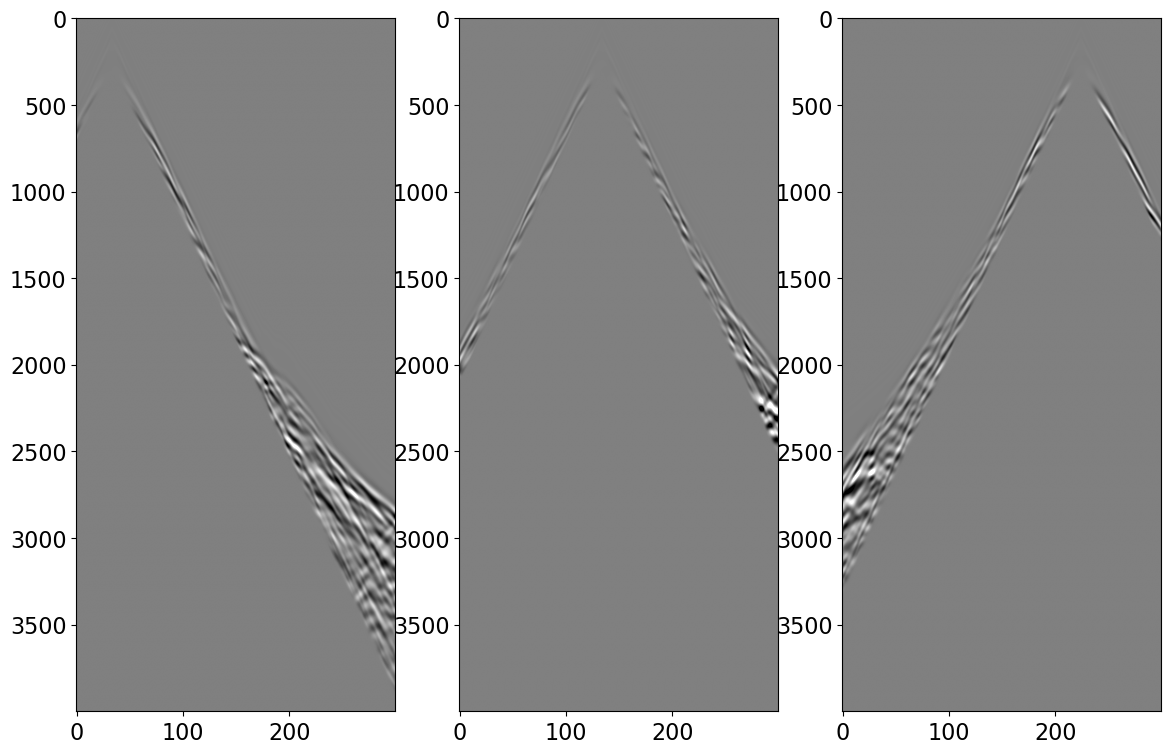

In [19]:
# Display modelling error
ntmax = 4000
d_vmin, d_vmax = np.percentile(np.hstack(dinv).ravel(), [2, 98])

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
for ax, ishot in zip(axs, [0, par['ns']//2, par['ns']-1]):
    ax.imshow(dobs_masked[ishot, :ntmax] - dinv_masked[ishot, :ntmax], aspect='auto', cmap='gray',
              vmin=-d_vmax, vmax=d_vmax)